# pylenspice: Python wrapper for PolSpice for weak lensing data sets

## Example: cross-correlation between KiDS and tSZ from Planck

### Setup

Import what we need and define a helper function to bin the Cls we get from PolSpice

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

import pylenspice

import os

pi = np.pi

def bin_C_ell(ell, C_ell, n_bin, ell_min, ell_max):
    bin_edges = np.linspace(ell_min, ell_max, n_bin+1, endpoint=True)
    bin_centers = (bin_edges[1:]+bin_edges[:-1])/2
    bins = np.zeros(n_bin)
    err = np.zeros(n_bin)
    ell_mean = np.zeros_like(bins)
    for i in range(n_bin):
        mask = np.logical_and(bin_edges[i] < ell, ell <= bin_edges[i+1])
        bins[i] = np.mean(C_ell[mask])
        err[i] = np.std(C_ell[mask])/np.sqrt(1.0*np.count_nonzero(mask))
        ell_mean[i] = np.mean(ell[mask])

    return bins, err, bin_centers

Set the paths for the input and output files.

In [2]:
nside = 2048

polspice_path = "/home/tilman/lib/polspice/PolSpice_v03-04-01/src/spice"

shear_healpix_path = "/data/tilman/polspice/pylenspice/example/data/shear/"
shear_catalog_filename = "/shared_data/KiDS/KiDS-450/DR3.1/KiDS_DR3.1_{}_ugri_shear.fits"

tSZ_healpix_path = "/data/tilman/polspice/pylenspice/example/data/tSZ/"
Planck_SZ_path = "/shared_data/Planck_data/COM_Compton_SZMap_R2.00/"

cl_path = "/data/tilman/polspice/pylenspice/example/results/"

### Set up the lensing data sets

In [3]:
KiDS_column_names = {"x" : "RAJ2000",
                     "y" : "DECJ2000",
                     "e1": "e1",
                     "e2": "e2",
                     "w" : "weight",
                     "m" : "m",
                     "z" : "z_B"}

KiDS_selection = [("weight", "gt", 0.0),
                  ("SG_FLAG", "eq", 1),
                  ("fitclass", "eq", 0)]

KiDS_fields = ["G9", "G12", "G15", "G23", "GS"]

z_min = 0.3
z_max = 1.1

shear_catalogs = [shear_catalog_filename.format(field) for field in KiDS_fields]

shear_output_filenames = {"triplet" :        os.path.join(shear_healpix_path, "triplet.fits"),
                          "singlet_mask" :   os.path.join(shear_healpix_path, "singlet_mask.fits"),
                          "doublet_mask" :   os.path.join(shear_healpix_path, "doublet_mask.fits"),
                          "doublet_weight" : os.path.join(shear_healpix_path, "doublet_weight.fits")}

Create the healpix shear maps

In [ ]:
pylenspice.create_shear_healpix_triplet(shear_catalogs=shear_catalogs, out_filenames=shear_output_filenames, 
                                        hdu_idx=1, nside=nside, flip_e1=True, convert_to_galactic=True,
                                        partial_maps=True, 
                                        c_correction="data", m_correction="catalog", column_names=KiDS_column_names, 
                                        selections=KiDS_selection,
                                        z_min=z_min, z_max=z_max)

### Set up the tSZ map

Since the shear is specified with respect to celestial coordinates, the tSZ map needs
to be converted to celestial coordinates. We put in a format that plays nicely with 
PolSpice in the same step. 

In [5]:
# The Compton y parameter map 
tSZ_map = {"file" : os.path.join(Planck_SZ_path, "milca_ymaps.fits"), "field" : 0}
# Two masks: point sources and a mask of Galactic foregrounds
tSZ_masks = [{"file" : os.path.join(Planck_SZ_path, "masks.fits"), "field" : 0},
             {"file" : os.path.join(Planck_SZ_path, "masks.fits"), "field" : 4},]

  
tSZ_output_filenames = { "triplet" : os.path.join(tSZ_healpix_path, "tSZ_triplet_full.fits"),
                         "doublet_mask" : os.path.join(tSZ_healpix_path, "tSZ_doublet_mask.fits"),
                         "singlet_mask" : os.path.join(tSZ_healpix_path, "tSZ_singlet_mask.fits")}

And create the tSZ map in the right format for PolSpice.

In [ ]:
footprint_file = os.path.join(shear_healpix_path, "doublet_mask.fits")

pylenspice.create_foreground_healpix_triplet(tSZ_map, tSZ_masks, tSZ_output_filenames, nside, 
                                             coord_in="G", coord_out="G", 
                                             footprint_file=footprint_file
                                            )


### Set up PolSpice

In [7]:
params={"mapfile" : os.path.join(shear_healpix_path, "triplet.fits"),
        "maskfile" : os.path.join(shear_healpix_path, "singlet_mask.fits"),
        "maskfilep" : os.path.join(shear_healpix_path, "doublet_mask.fits"),
        "weightfile" : os.path.join(shear_healpix_path, "singlet_mask.fits"),
        "weightfilep" : os.path.join(shear_healpix_path, "doublet_weight.fits"),
        "mapfile2" : os.path.join(tSZ_healpix_path, "tSZ_triplet_full.fits"),
        "maskfile2" : os.path.join(tSZ_healpix_path, "tSZ_singlet_mask.fits"),
        "polarization" : "YES",
        "clfile" : os.path.join(cl_path, "spice.cl"),
        "corfile" : os.path.join(cl_path, "spice.corr"),
        "kernelsfileout" : os.path.join(cl_path, "spice.kernels"),
        "thetamax" : 60.0,
        "apodizesigma" : 60.0,
        "nlmax" : 3000,
        "decouple" : "YES",
        "verbosity" : 2}

Run PolSpice,

In [ ]:
pylenspice.run_polspice(polspice_path, **params)

### Plot the results

If map1 in PolSpice is the shear map, then the cross-spectra are in column 7 and 8.

Text(0.5,1,'KiDS-450 (0.3 ≤ z < 1.1) X tSZ (Planck MILCA)')

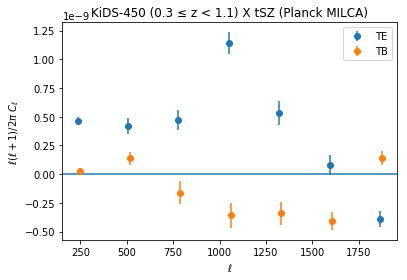

In [9]:
ell, C_ell_TE, C_ell_TB = np.loadtxt(os.path.join(cl_path, "spice.cl"), unpack=True, usecols=[0,7,8])

n_bin = 7
ell_min = 100
ell_max = 2000

C_ell_TE_binned, C_ell_TE_binned_err, binned_ell = bin_C_ell(ell, C_ell_TE, n_bin, ell_min, ell_max)
C_ell_TB_binned, C_ell_TB_binned_err, binned_ell = bin_C_ell(ell, C_ell_TB, n_bin, ell_min, ell_max)

units = binned_ell*(binned_ell+1)/(2*pi)

plt.errorbar(binned_ell, units*C_ell_TE_binned, units*C_ell_TE_binned_err, ls="none", marker="o", label="TE")
plt.errorbar(binned_ell+10, units*C_ell_TB_binned, units*C_ell_TB_binned_err, ls="none", marker="o", label="TB")
plt.axhline()
plt.legend()
plt.xlabel(r"$\ell$")
plt.ylabel(r"$\ell(\ell+1)/2\pi\ C_\ell$")

plt.title("KiDS-450 ({} ≤ z < {}) X tSZ (Planck MILCA)".format(z_min, z_max))